# Simulating phenotypes

- Mock example with very small sample size and number of SNPs
- Simple example using 2 components (genetic and noise), and bi-allelic SNPs
- Frequencies to sample alleles: 0.1, 0.2, 0.3

# Functions

In [388]:
library(data.table)

simGenotype = function(N = 50, nSNP = 30, frequencies = c(0.1, 0.2, 0.4)) {
    sps = paste0("%0", nchar(as.character(N)), "d")
    spsn = paste0("%0", nchar(as.character(nSNP)), "d")
    
    samples = paste0("ID_", sprintf(sps, 1:N))
    snps = paste0("SNP_", sprintf(spsn, 1:nSNP))
    freq = sample(frequencies, nSNP, replace = TRUE)
    X <- sapply(1:nSNP, function(x) rbinom(N, 2, freq[x]))
    colnames(X) <- snps
    rownames(X) <- samples
    return(X)
}


geneticEffects = function (genotype, causalSNP = 10, mBeta = 0, sdBeta = 1) {
    cSNP = sort(sample(colnames(genotype), causalSNP, replace = FALSE))
    betas = rnorm(causalSNP, mBeta, sdBeta)
    g = colnames(genotype)
    effects = rep(0, length(g))
    effects[g %in% cSNP] = betas
    names(effects) = g
    return(effects)
}

createPairs = function(trait, random_mating = 0.5, groups = 10) {
    tt = trait[, .(id, trait)]
    tt[, g := cut(trait , quantile(trait, probs = (0:groups)/groups),
        labels = FALSE, include.lowest = TRUE)]

    pairs = NULL
    for (i in 1:nrow(tt)) {
        if (nrow(tt) >= 2) {
            if (runif(1) < random_mating) {
                cc = tt[sample(.N, 2)]$id
                tt = tt[!id %in% cc]
                pairs = rbind(pairs, as.vector(cc))}
            else {
                sid = tt[sample(.N, 1)]$id
                sg = tt[id == sid]$g
                tt = tt[!id %in% sid]
                aid = tt[g == sg][sample(.N, 1)]$id
                if (length(aid) == 0) { aid = tt[sample(.N, 1)]$id }
                tt = tt[!id %in% aid]
                pairs = rbind(pairs, c(sid, aid))
            }
        }
    }
    return(pairs)
}


createCouples = function(genotype, trait, random_mating = 0.5) {
    temp = rownames(genotype)
    pairs = createPairs(trait, random_mating = random_mating)
    couples = list()
    snps = colnames(genotype)
    for (i in 1:nrow(pairs)) {
        temp = data.table(t(genotype[pairs[i,], ]))
        rownames(temp) = snps 
        couples[[i]] = temp
    }
    return(couples)
}


reproduce = function(couples, nkids = 2) {

    # mendelian rules (very important)
    m = matrix(c(1, 0, 0, 0.5, 0.5, 0, 0, 1, 0, 0.25, 0.50, 0.25, 0, 0.50, 0.5, 0, 0, 1), 
        nrow = 6, ncol = 3, byrow  = TRUE)       
    colnames(m) = c(0, 1, 2)
    rownames(m) = c("00", "01", "02", "11", "12", "22")
    
    kids = list()
    
    family = data.table()
    j = 1

    for (i in seq_along(couples)) {
        for (ii in 1:nkids) {
            temp = couples[[i]]
            fids = colnames(temp)
            temp$k = temp[, apply(.SD, 1, getKidGenotype, matrix = m)]
            temp = temp[, .(k)]
            setnames(temp, "k", paste0("ID_", j))
            temp[, snp := rownames(couples[[1]])]
            kids[[paste0(i, ii)]] = temp

            family = rbind(family, data.table(father = fids[1], mother = fids[2], kid = paste0("ID_", j)))
            j = j+1
        }
    }

    kk = Reduce(function(...) merge(...,  by = "snp"), kids)
    kk[, snp := NULL]
    kk = as.matrix(t(kk))
    colnames(kk) = rownames(couples[[1]])
    return(list(kk, family))
}


# function to get offspring genotype
getKidGenotype = function(values, matrix) {
    comba = paste0(values, collapse = "")
    combb = paste0(rev(values), collapse = "")
    s = grep(paste0(comba, "|", combb), rownames(matrix))
    prob = as.vector(matrix[s, ])
    return(sample(0:2, size = 1, prob = prob))
}


simKidTrait = function(kids, ge) {
    return(kids[[1]] %*% ge)
}


getNoiseComponent = function(genotype, mNoise = 0, sdNoise = 1) {
    n = nrow(genotype)
    return(rnorm(n, mNoise, sdNoise))
}


rescaleVar = function(component, prop) {
    component = as.vector(component) 
    var_component = var(component)
    scale_factor = sqrt(prop/var_component)
    return(component * scale_factor)
}


scalingFactor = function(component, prop) {
    component = as.vector(component) 
    var_component = var(component)
    return(sqrt(prop/var_component))
}

# Initial example
- 1000 people
- 100 snps
- 50 causal

In [379]:
gen = 0.3
noise = 1 - gen
genotype = simGenotype(3000, 300)
ge = geneticEffects(genotype, 50, sdBeta = 0.175)


In [383]:
# print(as.vector(ge))

In [384]:
parentGComp = (genotype %*% ge)
parentNComp = getNoiseComponent(genotype)

In [385]:
var(parentGComp) / var(parentGComp + parentNComp)
var(parentNComp) / var(parentGComp + parentNComp)

0.3192659


0.713052


In [ ]:
parentGComp = genotype %*% ge
pgsf = scalingFactor(parentGComp, gen)
pnsf = scalingFactor(parentNComp, noise)
parentTrait = parentGComp * pgsf + parentNComp * pnsf
dparentTrait = data.table(id = rownames(parentTrait), trait = parentTrait[, 1])

In [85]:
head(genotype)

,SNP_001,SNP_002,SNP_003,SNP_004,SNP_005,SNP_006,SNP_007,SNP_008,SNP_009,SNP_010,⋯,SNP_291,SNP_292,SNP_293,SNP_294,SNP_295,SNP_296,SNP_297,SNP_298,SNP_299,SNP_300
ID_0001,0,0,0,1,1,0,0,0,0,1,⋯,0,1,0,0,0,0,0,0,0,1
ID_0002,1,0,0,1,0,1,0,0,0,1,⋯,0,0,1,0,0,0,0,0,0,2
ID_0003,1,0,0,1,0,1,0,0,0,1,⋯,1,1,0,0,1,0,0,0,2,0
ID_0004,1,1,0,1,1,0,0,0,1,1,⋯,0,0,0,1,0,0,0,0,1,1
ID_0005,2,1,0,2,1,2,1,0,1,0,⋯,1,1,0,0,0,1,0,0,1,0
ID_0006,0,1,1,1,0,0,0,0,0,1,⋯,0,2,0,0,0,0,1,0,1,1


In [88]:
head(kids[[1]])

,SNP_001,SNP_002,SNP_003,SNP_004,SNP_005,SNP_006,SNP_007,SNP_008,SNP_009,SNP_010,⋯,SNP_291,SNP_292,SNP_293,SNP_294,SNP_295,SNP_296,SNP_297,SNP_298,SNP_299,SNP_300
ID_1,0,0,0,0,2,1,1,0,0,0,⋯,1,0,1,0,0,1,0,0,1,1
ID_2,0,0,0,1,2,1,1,1,0,0,⋯,1,1,1,0,1,0,1,0,1,0
ID_3,1,0,0,0,0,0,0,0,0,1,⋯,1,1,1,0,0,0,0,0,2,0
ID_4,1,0,0,0,1,0,1,0,0,0,⋯,0,1,1,0,0,0,0,0,1,1
ID_5,1,0,0,2,1,2,0,1,0,0,⋯,1,1,0,0,0,1,1,0,1,0
ID_6,1,1,0,0,1,2,0,2,1,0,⋯,1,2,0,2,0,1,0,0,1,1


In [90]:
# correlation between phenotypes
cor(dkidTrait[, .(trait, tfather, tmother)])

,trait,tfather,tmother
trait,1.0000000,0.18313253,0.15145904
tfather,0.1831325,1.00000000,0.01713349
tmother,0.1514590,0.01713349,1.00000000


In [91]:
# variance composition parents
paste0("Genetic part: ", round(var(parentGComp[, 1] * pgsf)/var(parentTrait[, 1]), 2))
paste0("Noise part: ", round(var(parentNComp * pnsf) /var(parentTrait[, 1]), 2))

[1] "Genetic part: 0.29"

[1] "Noise part: 0.68"

In [92]:
# variance composition kids
paste0("Genetic part: ", round(var(kidGComp[, 1] * pgsf)/var(kidTrait[, 1]), 2))
paste0("Noise part: ", round(var(kidNComp * pnsf) /var(kidTrait[, 1]), 2))

[1] "Genetic part: 0.27"

[1] "Noise part: 0.7"

# Several generations

In [414]:
# function to create several generations
# very inefficient function
createGenerations = function(nGen = 3, N = 1000, nSNP = 100, causalSNP = 50, genVar = 0.3, 
    genotype = NULL, effects = NULL, random_mating = 1) {
    noise = 1 - genVar
    if (is.null(genotype)) { genotype = simGenotype(N, nSNP) }
    if (is.null(effects)) { effects = geneticEffects(genotype, causalSNP, sdBeta = 0.175) }
    print(table(ge[ge != 0] > 0))
    traits = list()

    parentGComp = genotype %*% effects
    parentNComp = getNoiseComponent(genotype)

    #pgsf = scalingFactor(parentGComp, gen)
    #pnsf = scalingFactor(parentNComp, noise)
    # parentTrait = parentGComp * pgsf + parentNComp * pnsf
    parentTrait = parentGComp + parentNComp 
    dparentTrait = data.table(id = rownames(parentTrait), trait = parentTrait[, 1])
    
    kids = NULL
    for (i in 1:nGen) {
        print(paste0("::::::: creating generation: ", i))
        if (i == 1) {
            couples = createCouples(genotype, dparentTrait, random_mating = random_mating)
            kids = reproduce(couples)
            # genetic part
            kidGComp = kids[[1]] %*%  effects
            # noise part
            kidNComp = getNoiseComponent(kids[[1]])
            # trait
            #kidTrait = kidGComp * pgsf + kidNComp * pnsf
            kidTrait = kidGComp + kidNComp
            dkidTrait = data.table(id = rownames(kidTrait), trait = kidTrait[, 1])
            # merge traits
            family = kids[[2]]
            dkidTrait = merge(dkidTrait, family, by.x = "id", by.y = "kid")
            dkidTrait = merge(dkidTrait, dparentTrait[, .(id, father_trait = trait)], by.x = "father", by.y = "id", all.x = TRUE)
            dkidTrait = merge(dkidTrait, dparentTrait[, .(id, mother_trait = trait)], by.x = "mother", by.y = "id", all.x = TRUE)
            traits[[i]] = dkidTrait
        } else {
            couples = createCouples(kids[[1]], dkidTrait, random_mating = random_mating)
            kids = reproduce(couples)
            dparentTrait = dkidTrait
            # genetic part
            kidGComp = kids[[1]] %*%  effects
            # noise part
            kidNComp = getNoiseComponent(kids[[1]])
            # trait
            #kidTrait = kidGComp * pgsf + kidNComp * pnsf
            kidTrait = kidGComp + kidNComp
            dkidTrait = data.table(id = rownames(kidTrait), trait = kidTrait[, 1])
            # merge traits
            family = kids[[2]]
            dkidTrait = merge(dkidTrait, family, by.x = "id", by.y = "kid")
            dkidTrait = merge(dkidTrait, dparentTrait[, .(id, father_trait = trait)], by.x = "father", by.y = "id", all.x = TRUE)
            dkidTrait = merge(dkidTrait, dparentTrait[, .(id, mother_trait = trait)], by.x = "mother", by.y = "id", all.x = TRUE)
            traits[[i]] = dkidTrait
        }   
    }
    return(rbindlist(traits, idcol = "generation"))
}

# Some assortative mating

In [430]:
gen = 0.3
noise = 1 - gen
genotype = simGenotype(1000, 200)
ge = geneticEffects(genotype, 50, sdBeta = 0.175)

In [431]:
prop.table(table(ge[ge != 0] > 0))


FALSE  TRUE 
  0.4   0.6 

In [441]:
tt = createGenerations(nGen = 30, genotype = genotype, effects = ge, random_mating = 0.80)


FALSE  TRUE 
   20    30 
[1] "::::::: creating generation: 1"
[1] "::::::: creating generation: 2"
[1] "::::::: creating generation: 3"
[1] "::::::: creating generation: 4"
[1] "::::::: creating generation: 5"
[1] "::::::: creating generation: 6"
[1] "::::::: creating generation: 7"
[1] "::::::: creating generation: 8"
[1] "::::::: creating generation: 9"
[1] "::::::: creating generation: 10"
[1] "::::::: creating generation: 11"
[1] "::::::: creating generation: 12"
[1] "::::::: creating generation: 13"
[1] "::::::: creating generation: 14"
[1] "::::::: creating generation: 15"
[1] "::::::: creating generation: 16"
[1] "::::::: creating generation: 17"
[1] "::::::: creating generation: 18"
[1] "::::::: creating generation: 19"
[1] "::::::: creating generation: 20"
[1] "::::::: creating generation: 21"
[1] "::::::: creating generation: 22"
[1] "::::::: creating generation: 23"
[1] "::::::: creating generation: 24"
[1] "::::::: creating generation: 25"
[1] "::::::: creating generation

In [442]:
dtt = tt[, .(average = mean(trait), 
    sd = sd(trait),
    cor_kid_father = cor(trait, father_trait), 
    cor_kid_mother = cor(trait, mother_trait), 
    cor_father_mother = cor(father_trait, mother_trait)), generation]
dtt

generation,average,sd,cor_kid_father,cor_kid_mother,cor_father_mother
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.155146,1.282206,0.2457442,0.2423351,0.31084228
2,1.160075,1.307275,0.2882298,0.2138097,0.13983862
3,1.154918,1.294242,0.2219991,0.2679698,0.15652406
4,1.116471,1.277785,0.3008681,0.2668567,0.30452406
5,1.141831,1.292848,0.1969512,0.1692692,0.19844335
6,1.233925,1.285306,0.2350891,0.2510906,0.08398452
7,1.263636,1.280787,0.2784071,0.2555901,0.23733049
8,1.277833,1.264917,0.2365755,0.2252336,0.15794876
9,1.197425,1.293795,0.2091419,0.1763515,0.14318484


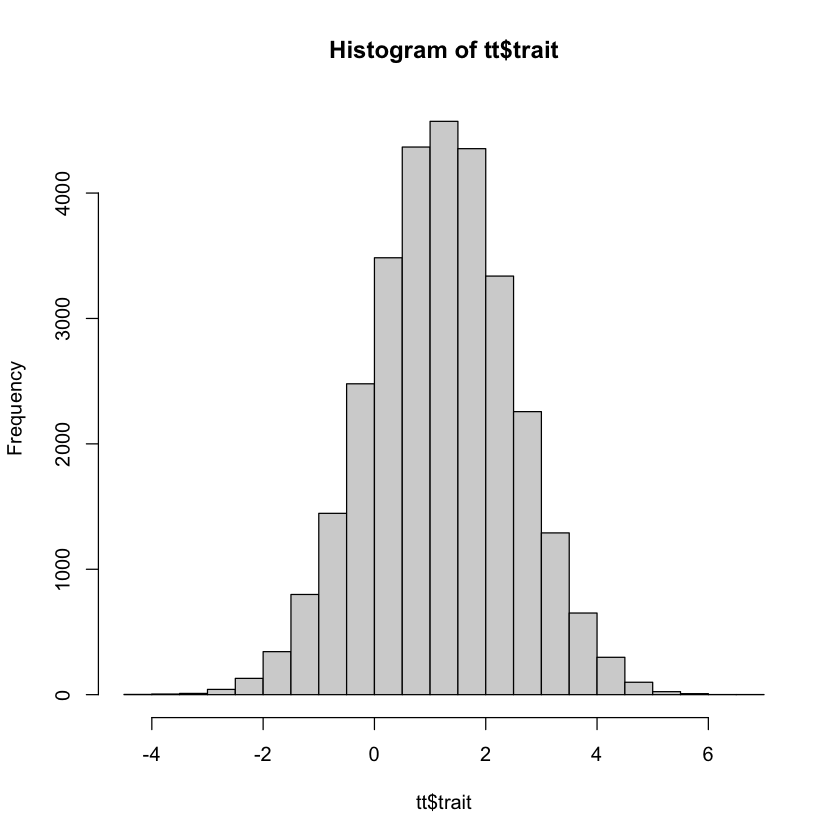

In [443]:
hist(tt$trait)

# Random mating

There seems to be issues with the scaling.

In [444]:
cc = createGenerations(nGen = 30, genotype = genotype, effects = ge, random_mating = 1.0)


FALSE  TRUE 
   20    30 
[1] "::::::: creating generation: 1"
[1] "::::::: creating generation: 2"
[1] "::::::: creating generation: 3"
[1] "::::::: creating generation: 4"
[1] "::::::: creating generation: 5"
[1] "::::::: creating generation: 6"
[1] "::::::: creating generation: 7"
[1] "::::::: creating generation: 8"
[1] "::::::: creating generation: 9"
[1] "::::::: creating generation: 10"
[1] "::::::: creating generation: 11"
[1] "::::::: creating generation: 12"
[1] "::::::: creating generation: 13"
[1] "::::::: creating generation: 14"
[1] "::::::: creating generation: 15"
[1] "::::::: creating generation: 16"
[1] "::::::: creating generation: 17"
[1] "::::::: creating generation: 18"
[1] "::::::: creating generation: 19"
[1] "::::::: creating generation: 20"
[1] "::::::: creating generation: 21"
[1] "::::::: creating generation: 22"
[1] "::::::: creating generation: 23"
[1] "::::::: creating generation: 24"
[1] "::::::: creating generation: 25"
[1] "::::::: creating generation

In [445]:
dcc = cc[, .(average = mean(trait), 
    sd = sd(trait),
    cor_kid_father = cor(trait, father_trait), 
    cor_kid_mother = cor(trait, mother_trait), 
    cor_father_mother = cor(father_trait, mother_trait)), generation]
dcc

generation,average,sd,cor_kid_father,cor_kid_mother,cor_father_mother
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.133469,1.280992,0.2094650,0.1767724,0.0077005045
2,1.159201,1.259338,0.2208825,0.2168109,-0.0597746167
3,1.128385,1.284331,0.1554042,0.2098005,-0.0127529152
4,1.092859,1.315847,0.2122855,0.2643635,-0.0195151114
5,1.045543,1.275029,0.2133591,0.2088947,0.0157504448
6,1.091707,1.294651,0.1546631,0.1905424,-0.0849780122
7,1.101938,1.281856,0.1949146,0.2037451,0.0026857017
8,1.080910,1.293322,0.1922613,0.2044802,-0.0589101351
9,1.074337,1.252413,0.2022943,0.2882389,0.0211631843


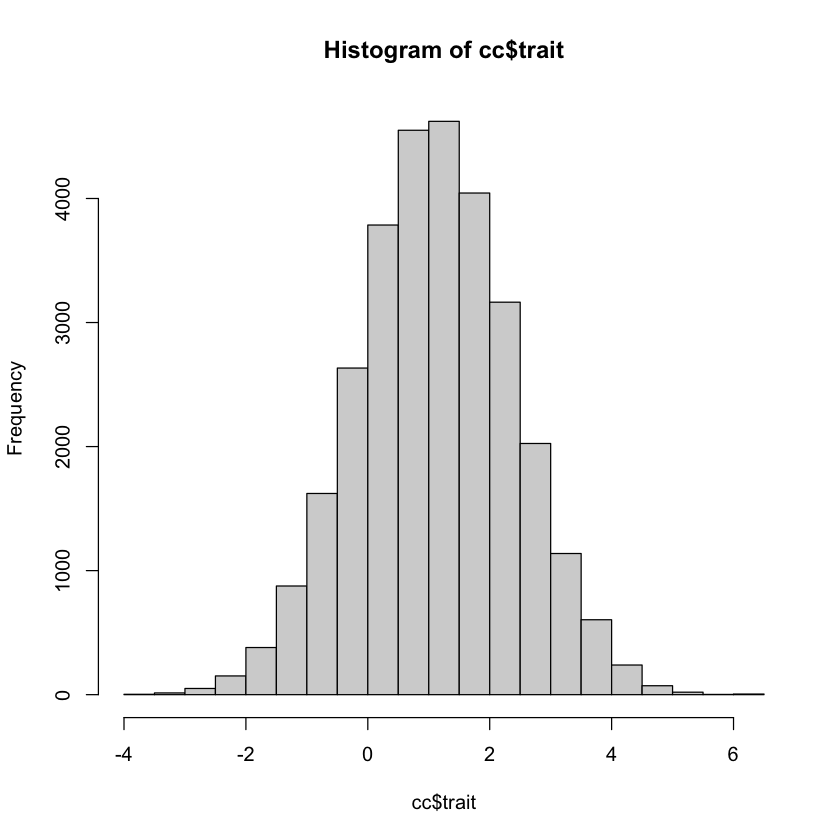

In [450]:
hist(cc$trait)

In [447]:
sd(cc[generation == 30, trait])
sd(tt[generation == 30, trait])

[1] 1.257585

[1] 1.303766

In [449]:
summary(cc[generation == 30, trait])
summary(tt[generation == 30, trait])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-3.4628  0.3096  1.0736  1.1111  1.9668  4.8060 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -2.546   0.375   1.246   1.235   2.107   6.590 